<a href="https://colab.research.google.com/github/linainsaf/Biometrics/blob/main/GAN_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BIoMétrie : Generative Adversarial Networks

### Import librairies 

In [4]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from numpy import vstack
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from keras.layers import Flatten,Conv2D,LeakyReLU,Dense,Conv2DTranspose,Reshape,Dropout,BatchNormalization,Activation


from IPython import display
from numpy import zeros, ones, expand_dims, asarray
from numpy.random import randn
from keras.models import Model, load_model,Sequential
from keras.layers import Input, Concatenate, Embedding
from keras import initializers
from keras.initializers import RandomNormal
from math import sqrt


### Load Dataset

In [ ]:
(X_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32) / 127.5 - 1

11501568/11490434 [==============================] - 0s 0us/step


### Plot some images from the training set

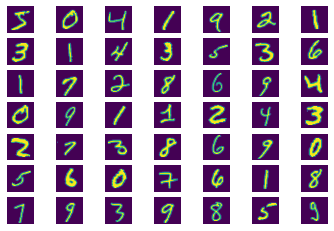

In [ ]:
# example of loading and plotting the MNIST dataset
# plot images from the training dataset
for i in range(49):
    # define subplot
    plt.subplot(7, 7, 1 + i)
    # turn off axis
    plt.axis('off')
    # plot raw pixel data
    plt.imshow(X_train[i])
plt.show()

### Reshape Training data for DeepLearning : 

In [ ]:
X_train = np.expand_dims(X_train, axis=3)
print(X_train.shape)

(60000, 28, 28, 1)


### Instanciation of G and D

#### Define Generator : 

In [ ]:
def define_generator(latent_dim): 
    init = RandomNormal(stddev=0.02)
    in_lat = Input(shape=(latent_dim,)) 
    gen = Dense(256, kernel_initializer=init)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(512, kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(1024, kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Dense(28 * 28 * 1, kernel_initializer=init)(gen)
    out_layer = Activation('tanh')(gen)
    out_layer = Reshape((28, 28, 1))(gen)
    model = Model(in_lat, out_layer)
    return model

In [ ]:
generator = define_generator(100)
generator.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 100)]             0         
                                                                 
 dense_72 (Dense)            (None, 256)               25856     
                                                                 
 leaky_re_lu_57 (LeakyReLU)  (None, 256)               0         
                                                                 
 dense_73 (Dense)            (None, 512)               131584    
                                                                 
 leaky_re_lu_58 (LeakyReLU)  (None, 512)               0         
                                                                 
 dense_74 (Dense)            (None, 1024)              525312    
                                                                 
 leaky_re_lu_59 (LeakyReLU)  (None, 1024)              0  

#### Define Discriminator : 

In [ ]:
def define_discriminator(in_shape=(28, 28, 1)):
    init = RandomNormal(stddev=0.02)  
    in_image = Input(shape=in_shape)
    fe = Flatten()(in_image)
    fe = Dense(1024)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    fe = Dense(512)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    fe = Dense(256)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.3)(fe)
    out = Dense(1, activation='sigmoid')(fe)
    model = Model(in_image, out)
    opt = Adam(lr=0.0002, beta_1=0.5) 
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [ ]:
discriminator = define_discriminator()
discriminator.summary()

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_76 (Dense)            (None, 1024)              803840    
                                                                 
 leaky_re_lu_60 (LeakyReLU)  (None, 1024)              0         
                                                                 
 dropout_14 (Dropout)        (None, 1024)              0         
                                                                 
 dense_77 (Dense)            (None, 512)               524800    
                                                                 
 leaky_re_lu_61 (LeakyReLU)  (None, 512)               0  

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### Création du GAN

In [ ]:
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # define gan output
    gan_output = discriminator(generator.output)
    model = Model(generator.input, gan_output)
    # compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [ ]:
gan.summary()

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_70_input (InputLayer)  [(None, 100)]            0         
                                                                 
 dense_70 (Dense)            (None, 6272)              633472    
                                                                 
 leaky_re_lu_52 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_17 (Reshape)        (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_13 (Conv2D  (None, 14, 14, 128)      262272    
 Transpose)                                                      
                                                                 
 leaky_re_lu_53 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                          

### Apprentissage du GAN

In [ ]:
def generate_real_samples(X_train, n_samples):
    ix = randint(0, X_train.shape[0], n_samples) 
    X = X_train[ix]  
    y = ones((n_samples, 1)) 
    return X, y

def generate_fake_samples(generator, latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)  
    z_input = x_input.reshape(n_samples, latent_dim)
    images = generator.predict(z_input)  
    y = zeros((n_samples, 1))
    return images, y

In [ ]:
# train the generator and discriminator
def train(g, d, gan, X_train, latent_dim, epochs=100, batch=256):
  bat_per_epo = int(X_train.shape[0] / batch)
  half_batch = int(batch / 2)
  step = 0
  for i in range(epochs):
    print('epoch number :', i+1)
    for j in range(bat_per_epo):
      X_real, y_real = generate_real_samples(X_train, half_batch)
      d_loss_r, d_acc_r = d.train_on_batch(X_real, y_real)
      X_fake, y_fake = generate_fake_samples(g, latent_dim, half_batch)
      d_loss_f, d_acc_f = d.train_on_batch(X_fake, y_fake)
      X_gan = randn(latent_dim * batch)
      X_gan = X_gan.reshape(batch, latent_dim)
      y_gan = ones((batch, 1))
      g_loss = gan.train_on_batch(X_gan, y_gan)
    if (i+1) % 10 == 0:
      step +=1
      print('g_loss=%.3f, d_loss_real=%.3f, d_acc_real=%.3f, d_loss_fake=%.3f, d_acc_fake=%.3f' % (g_loss, d_loss_r, d_acc_r,d_loss_f,d_acc_f))
      print("Generated images at this epoch : ")
      X_gen = randn(latent_dim * batch)
      X_gen = X_gen.reshape(batch, latent_dim)
      X_gen  = g.predict(X_gen)
      X_gen = (X_gen + 1) / 2.0
      for a in range(10):
        plt.subplot(2, 5, 1 + a)
        plt.axis('off')
        plt.imshow(X_gen[a, :, :, 0], cmap='gray_r')
      plt.show()
      filename = 'model_%04d.h5' % (step+1)
      g.save(filename)
      print('>Saved: %s' % (filename))

In [ ]:
gan = define_gan(generator,discriminator)

epoch number : 1
epoch number : 2
epoch number : 3
epoch number : 4
epoch number : 5
epoch number : 6
epoch number : 7
epoch number : 8
epoch number : 9
epoch number : 10
g_loss=2.419, d_loss_real=0.472, d_acc_real=0.734, d_loss_fake=0.446, d_acc_fake=0.805
Generated images at this epoch : 


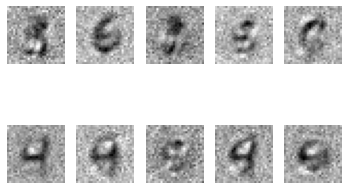

>Saved: model_0002.h5
epoch number : 11
epoch number : 12
epoch number : 13
epoch number : 14
epoch number : 15
epoch number : 16
epoch number : 17
epoch number : 18
epoch number : 19
epoch number : 20
g_loss=1.558, d_loss_real=0.489, d_acc_real=0.742, d_loss_fake=0.500, d_acc_fake=0.805
Generated images at this epoch : 


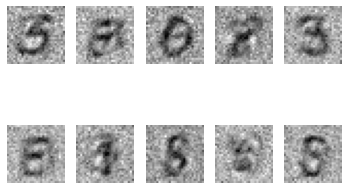

>Saved: model_0003.h5
epoch number : 21
epoch number : 22
epoch number : 23
epoch number : 24
epoch number : 25
epoch number : 26
epoch number : 27
epoch number : 28
epoch number : 29
epoch number : 30
g_loss=1.561, d_loss_real=0.617, d_acc_real=0.602, d_loss_fake=0.499, d_acc_fake=0.781
Generated images at this epoch : 


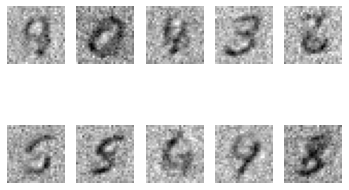

>Saved: model_0004.h5
epoch number : 31
epoch number : 32
epoch number : 33
epoch number : 34
epoch number : 35
epoch number : 36
epoch number : 37
epoch number : 38
epoch number : 39
epoch number : 40
g_loss=1.586, d_loss_real=0.555, d_acc_real=0.648, d_loss_fake=0.468, d_acc_fake=0.789
Generated images at this epoch : 


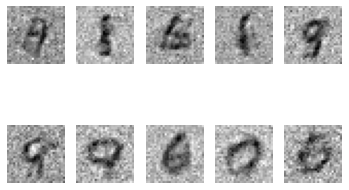

>Saved: model_0005.h5
epoch number : 41
epoch number : 42
epoch number : 43
epoch number : 44
epoch number : 45
epoch number : 46
epoch number : 47
epoch number : 48
epoch number : 49
epoch number : 50
g_loss=1.476, d_loss_real=0.503, d_acc_real=0.719, d_loss_fake=0.516, d_acc_fake=0.773
Generated images at this epoch : 


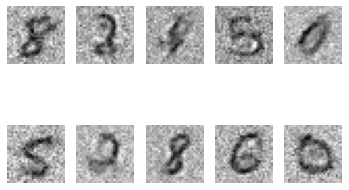

>Saved: model_0006.h5
epoch number : 51
epoch number : 52
epoch number : 53
epoch number : 54
epoch number : 55
epoch number : 56
epoch number : 57
epoch number : 58
epoch number : 59
epoch number : 60
g_loss=1.599, d_loss_real=0.508, d_acc_real=0.766, d_loss_fake=0.493, d_acc_fake=0.750
Generated images at this epoch : 


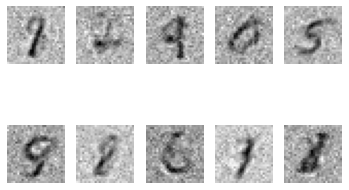

>Saved: model_0007.h5
epoch number : 61
epoch number : 62
epoch number : 63
epoch number : 64
epoch number : 65
epoch number : 66
epoch number : 67
epoch number : 68
epoch number : 69
epoch number : 70
g_loss=1.431, d_loss_real=0.479, d_acc_real=0.742, d_loss_fake=0.529, d_acc_fake=0.781
Generated images at this epoch : 


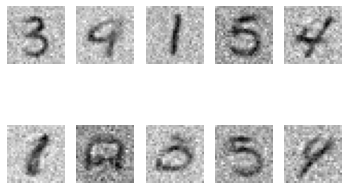

>Saved: model_0008.h5
epoch number : 71
epoch number : 72
epoch number : 73
epoch number : 74
epoch number : 75
epoch number : 76
epoch number : 77
epoch number : 78
epoch number : 79
epoch number : 80
g_loss=1.477, d_loss_real=0.591, d_acc_real=0.648, d_loss_fake=0.485, d_acc_fake=0.859
Generated images at this epoch : 


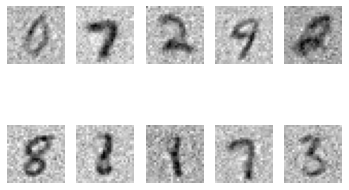

>Saved: model_0009.h5
epoch number : 81
epoch number : 82
epoch number : 83
epoch number : 84
epoch number : 85
epoch number : 86
epoch number : 87
epoch number : 88
epoch number : 89
epoch number : 90
g_loss=1.555, d_loss_real=0.568, d_acc_real=0.734, d_loss_fake=0.616, d_acc_fake=0.711
Generated images at this epoch : 


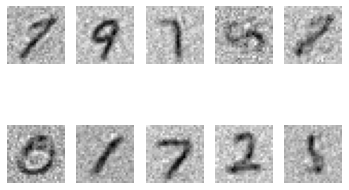

>Saved: model_0010.h5
epoch number : 91
epoch number : 92
epoch number : 93
epoch number : 94
epoch number : 95
epoch number : 96
epoch number : 97
epoch number : 98
epoch number : 99
epoch number : 100
g_loss=1.449, d_loss_real=0.522, d_acc_real=0.656, d_loss_fake=0.473, d_acc_fake=0.812
Generated images at this epoch : 


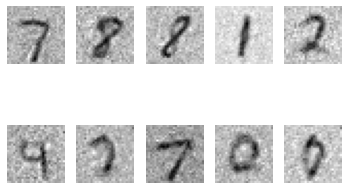

>Saved: model_0011.h5


In [ ]:
train(generator, discriminator, gan, X_train, 100)


In [ ]:
def generate_samples_and_plot(g,latent_dim,batch):
  X_gen = randn(latent_dim * batch)
  X_gen = X_gen.reshape(batch, latent_dim)
  X_gen  = g.predict(X_gen)
  X_gen = (X_gen + 1) / 2.0
  plt.figure(figsize=(10, 10))
  for a in range(50):
    plt.subplot(10, 5, 1 + a)
    plt.axis('off')
    plt.imshow(X_gen[a, :, :, 0], cmap='gray_r')
  plt.show()
  return X_gen

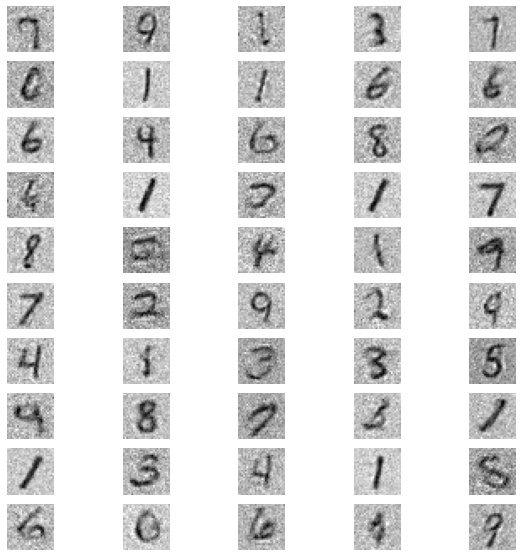

In [ ]:
g = load_model('model_0011.h5')
latent_dim=100
batch = 200
X_gen = generate_samples_and_plot(g,latent_dim,batch)